In [1]:
%load_ext autoreload
%autoreload 2
import torch 
import torch as th 
import torch.nn as nn
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Prep training data

In [3]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [5]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


### Example experiment

In [6]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [7]:
!ls {exproot}

BaseBlnr_RAVEN10_abstract_20240212-2142
BaseBlnr_RAVEN10_abstract_onehot_20240212-2143
BaseBlnrX3_new_RAVEN10_abstract_20240313-1736
BaseBlnrX3_new_RAVEN10_abstract_onehot_20240313-1736
base_cifar10_20240130-2317
base_cifar10_20240130-2318
base_gabor_prime_20240130-2251
base_gabor_sf_20240130-2306
base_mnist_20240129-1342
base_mnist_20240129-1406
base_mnist_20240130-2207
base_RAVEN10_20240131-2049
base_RAVEN10_abstract_20240201-0036
Base_RAVEN10_abstract_20240212-2139
base_RAVEN10_abstract_onehot_20240201-0147
Base_RAVEN10_abstract_onehot_20240212-2140
BBigBlnrX3_new_RAVEN10_abstract_20240313-1809
BBigBlnrX3_new_RAVEN10_abstract_onehot_20240313-1810
BBigBlnrX3_new_RAVEN10_abstract_onehot_20240314-0112
BBigBlnrX3_RAVEN10_abstract_20240305-2341
BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411
BigBlnr_RAVEN10_abstract_20240208-1709
BigBlnr_RAVEN10_abstract_onehot_20240209-0208
BigBlnrX3_new_RAVEN10_abstract_20240313-1753
BigBlnrX3_new_RAVEN10_abstract_20240315-1328
BigBlnrX3_new_RAVEN10_

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"WideBlnrX3_new_RAVEN10_abstract_20240315-1327"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
# state_dict = th.load(ckpt_path, )
# model.load_state_dict(state_dict["model"])
# model.to("cuda").eval();

In [ ]:
!ls {repr_dir}

In [56]:
def sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99], 
                            epoch_list=[-1, 20000, 40000, 100000, 200000, 500000, 700000,]):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            if epoch == -1:
                results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckptRNDINIT.pkl"), "rb"))
            else:
                results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckpt{epoch:07d}EMA.pkl"), "rb"))
            test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
            train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
            syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
            syn_df.columns = ["Test Accuracy", "Train Accuracy"]
            syn_df["t"] = t_scalar
            syn_df["epoch"] = epoch
            # drop index as layer name
            syn_df = syn_df.reset_index()
            syn_df = syn_df.rename(columns={"index": "Layer"})
            syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    return syn_df_all


def sweep_classifier_result_heldinout(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99], 
                            epoch_list=[-1, 20000, 40000, 100000, 200000, 500000, 700000,],
                            y_test=y_test, heldout_rules=heldout_rules):
    mask_heldout = torch.isin(y_test, th.tensor(heldout_rules))
    mask_in = ~mask_heldout
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            if epoch == -1:
                results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckptRNDINIT.pkl"), "rb"))
            else:
                results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckpt{epoch:07d}EMA.pkl"), "rb"))
            test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
            train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
            test_acc_synopsis_heldin = {}
            test_acc_synopsis_heldout = {}
            for key in results_col.keys():
                test_acc_synopsis_heldin[key] = (results_col[key]['pred_cls'].cpu()[mask_in] ==
                                                y_test[mask_in]).float().mean().item()
                test_acc_synopsis_heldout[key] = (results_col[key]['pred_cls'].cpu()[mask_heldout] ==
                                                y_test[mask_heldout]).float().mean().item()
            syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis, 
                                test_acc_synopsis_heldin, test_acc_synopsis_heldout]).T
            # raise ValueError()
            syn_df.columns = ["Test Accuracy", "Train Accuracy", 
                            "Test Accuracy Heldin", "Test Accuracy Heldout"]
            syn_df["t"] = t_scalar
            syn_df["epoch"] = epoch
            # drop index as layer name
            syn_df = syn_df.reset_index()
            syn_df = syn_df.rename(columns={"index": "Layer"})
            syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    return syn_df_all

In [41]:
mask_heldout = torch.isin(y_test, th.tensor(heldout_rules))
mask_in = ~mask_heldout

In [46]:
syn_df_all = []
# t_scalar = 0.1
for t_scalar in [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]:
    for epoch in [-1, 20000, 40000, 100000, 200000, 500000, 700000,]:
        t_str = str(t_scalar).replace(".", "_")
        if epoch == -1:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckptRNDINIT.pkl"), "rb"))
        else:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckpt{epoch:07d}EMA.pkl"), "rb"))
        test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        test_acc_synopsis_heldin = {}
        test_acc_synopsis_heldout = {}
        for key in results_col.keys():
            test_acc_synopsis_heldin[key] = (results_col[key]['pred_cls'].cpu()[mask_in] ==
                                            y_test[mask_in]).float().mean().item()
            test_acc_synopsis_heldout[key] = (results_col[key]['pred_cls'].cpu()[mask_heldout] ==
                                            y_test[mask_heldout]).float().mean().item()
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis, 
                               test_acc_synopsis_heldin, test_acc_synopsis_heldout]).T
        # raise ValueError()
        syn_df.columns = ["Test Accuracy", "Train Accuracy", 
                          "Test Accuracy Heldin", "Test Accuracy Heldout"]
        syn_df["t"] = t_scalar
        syn_df["epoch"] = epoch
        # drop index as layer name
        syn_df = syn_df.reset_index()
        syn_df = syn_df.rename(columns={"index": "Layer"})
        syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

In [47]:
syn_df_all

,Layer,Test Accuracy,Train Accuracy,Test Accuracy Heldin,Test Accuracy Heldout,t,epoch
0,input,0.237075,0.264367,0.212829,0.4068,0.05,-1
1,enc.9x9_conv,0.224850,0.277267,0.202314,0.3826,0.05,-1
2,enc.3x3_down,0.272675,0.324933,0.248686,0.4406,0.05,-1
3,enc.1x1_down,0.112875,0.120767,0.101200,0.1946,0.05,-1
4,dec.1x1_in0,0.118325,0.123975,0.105543,0.2078,0.05,-1
...,...,...,...,...,...,...,...
6,dec.3x3_up,0.623250,0.641467,0.612257,0.7002,0.99,700000
7,dec.9x9_up,0.727100,0.791583,0.718029,0.7906,0.99,700000
8,dec.9x9_block2,0.513625,0.572175,0.498629,0.6186,0.99,700000
9,dec.9x9_aux_norm,0.486000,0.543350,0.469229,0.6034,0.99,700000


<Axes: xlabel='Layer', ylabel='Test Accuracy'>

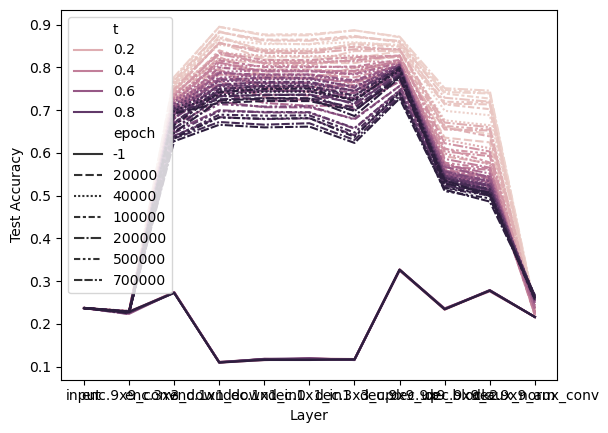

In [15]:
sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="t", style="epoch")
# syn_df_all.plot(x="Layer", y="Test Accuracy", hue="t", logy=True, figsize=(12, 8))

<Axes: xlabel='Layer', ylabel='Test Accuracy'>

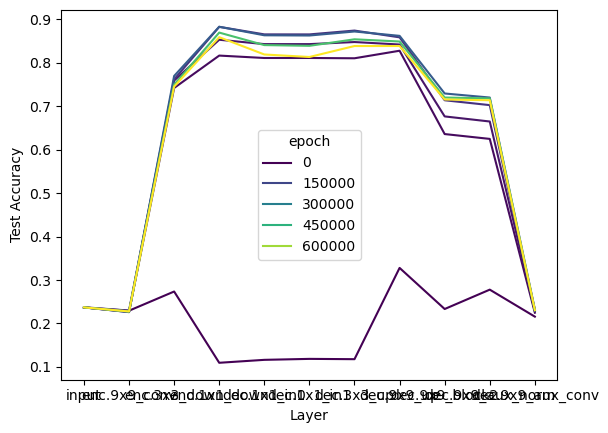

In [18]:
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], x="Layer", y="Test Accuracy", 
             hue="epoch", palette="viridis")

<Axes: xlabel='epoch', ylabel='Test Accuracy'>

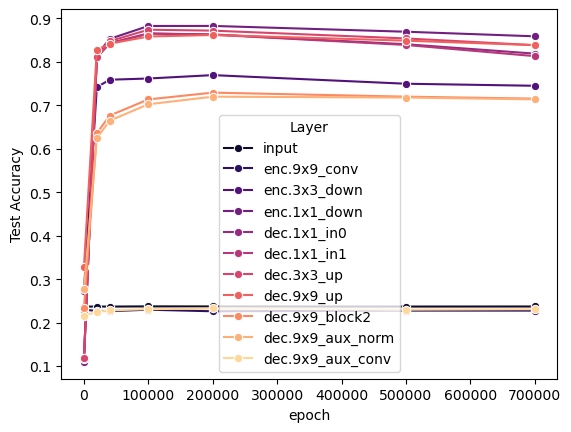

In [26]:
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], marker="o",
             x="epoch", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='epoch', ylabel='Test Accuracy Heldin'>

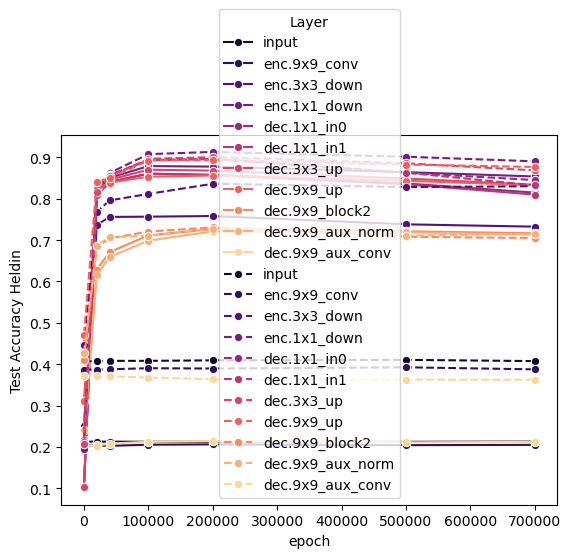

In [53]:
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], marker="o",
             x="epoch", y="Test Accuracy Heldin", hue="Layer", palette="magma")
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], marker="o",
             x="epoch", y="Test Accuracy Heldout", hue="Layer", palette="magma", linestyle="--")

<Axes: xlabel='epoch', ylabel='Test Accuracy Heldout'>

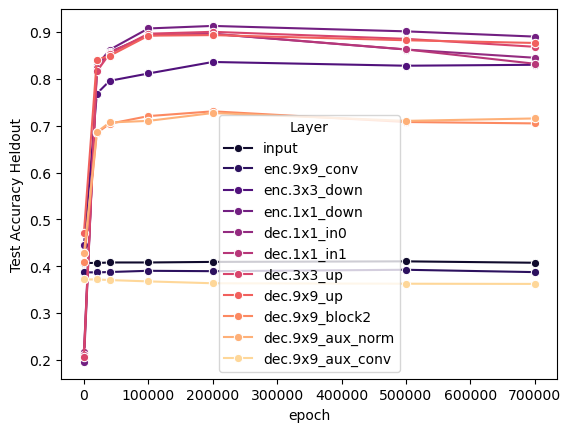

In [49]:
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], marker="o",
             x="epoch", y="Test Accuracy Heldout", hue="Layer", palette="magma")

<Axes: xlabel='t', ylabel='Test Accuracy'>

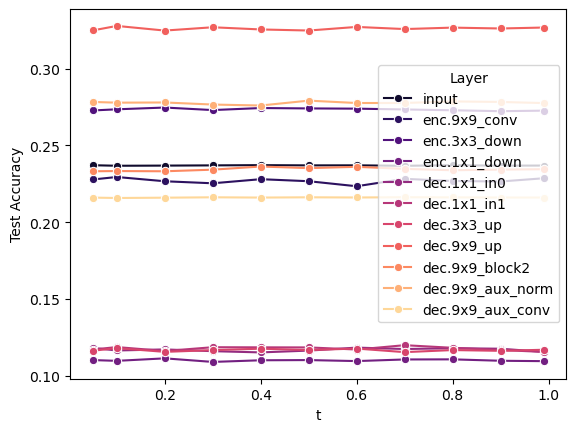

In [31]:
sns.lineplot(data=syn_df_all[syn_df_all["epoch"]==-1], marker="o",
             x="t", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='t', ylabel='Test Accuracy'>

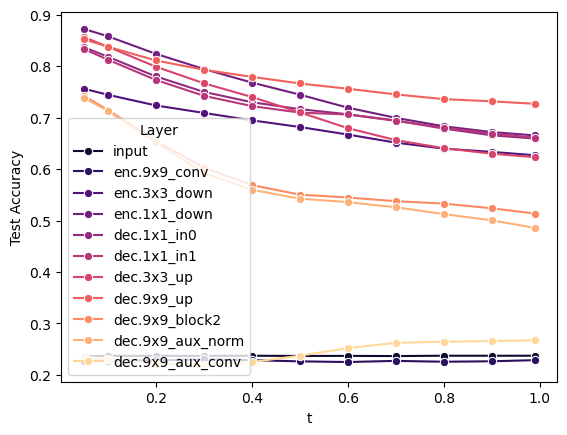

In [30]:
sns.lineplot(data=syn_df_all[syn_df_all["epoch"]==700000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='t', ylabel='Test Accuracy'>

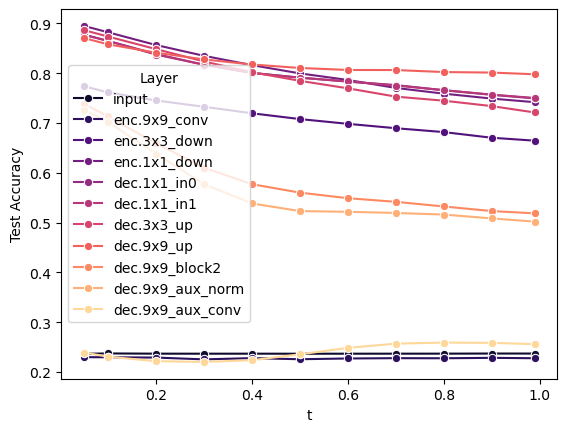

In [27]:
sns.lineplot(data=syn_df_all[syn_df_all["epoch"]==100000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='Layer', ylabel='Test Accuracy'>

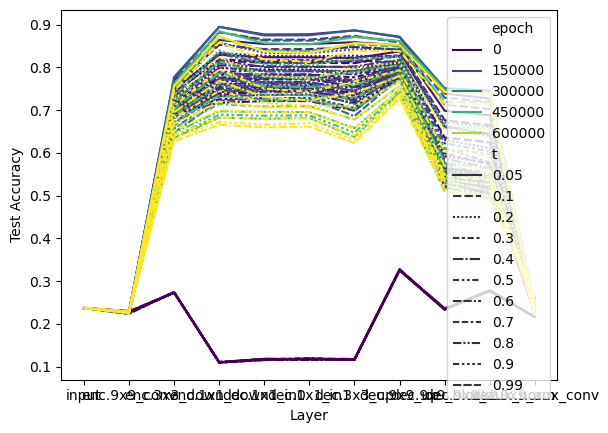

In [17]:
sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="epoch", style="t", palette="viridis")

In [38]:
syn_df_all["Test Accuracy"].max()
# find the row with max test accuracy
syn_df_all[syn_df_all["Test Accuracy"] == syn_df_all["Test Accuracy"].max()]

,Layer,Test Accuracy,Train Accuracy,t,epoch
3,enc.1x1_down,0.894875,0.917942,0.05,100000


In [39]:
syn_df_all["Test Accuracy"].max()

0.894875

In [35]:
syn_df_all["Train Accuracy"].max()

0.9398916666666667

### Base model

In [9]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"BaseBlnrX3_new_RAVEN10_abstract_20240313-1736"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
# ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_base = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

Text(0.5, 1.0, 'BaseBlnrX3_new_RAVEN10_abstract_20240313-1736\nTest Accuracy at epoch 100000')

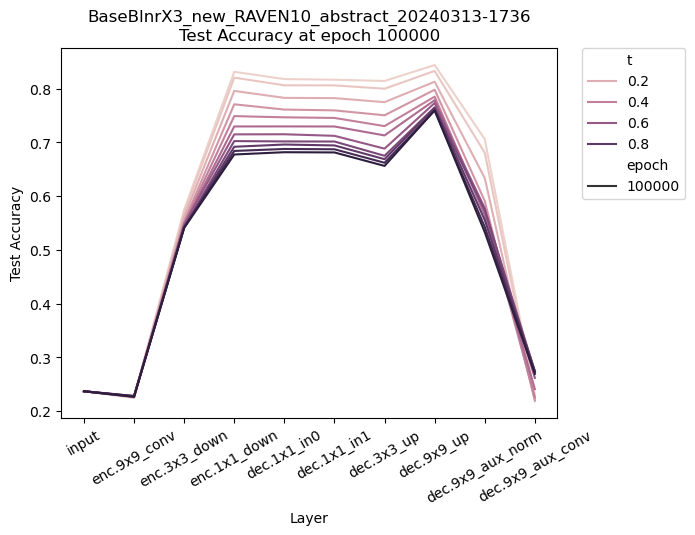

In [12]:
sns.lineplot(data=syn_df_all_base[syn_df_all_base["epoch"]==100000], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)
plt.title(f"{expname}\nTest Accuracy at epoch 100000")

Text(0.5, 1.0, 'BaseBlnrX3_new_RAVEN10_abstract_20240313-1736\nTest Accuracy at epoch 40000')

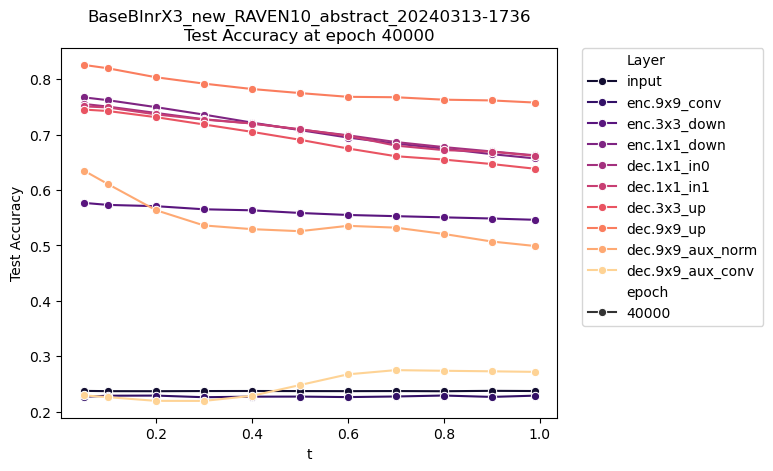

In [14]:
sns.lineplot(data=syn_df_all_base[syn_df_all_base["epoch"]==40000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"{expname}\nTest Accuracy at epoch 40000")

Text(0.5, 1.0, 'BaseBlnrX3_new_RAVEN10_abstract_20240313-1736\nTest Accuracy at epoch 100000')

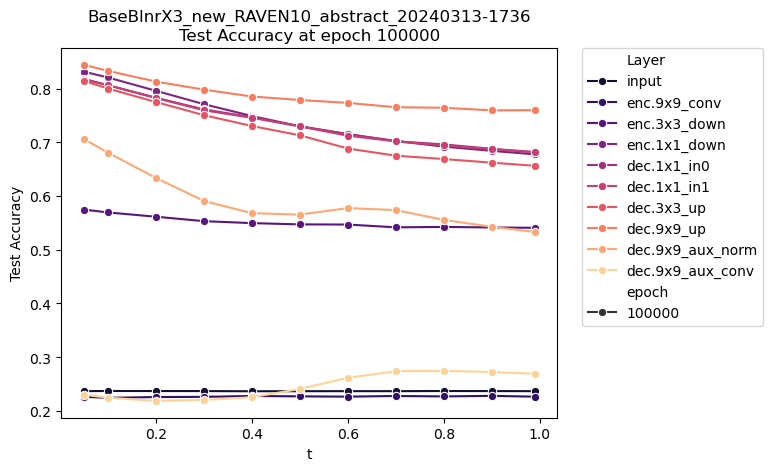

In [15]:
sns.lineplot(data=syn_df_all_base[syn_df_all_base["epoch"]==100000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"{expname}\nTest Accuracy at epoch 100000")

Text(0.5, 1.0, 'BaseBlnrX3_new_RAVEN10_abstract_20240313-1736\nTest Accuracy ')

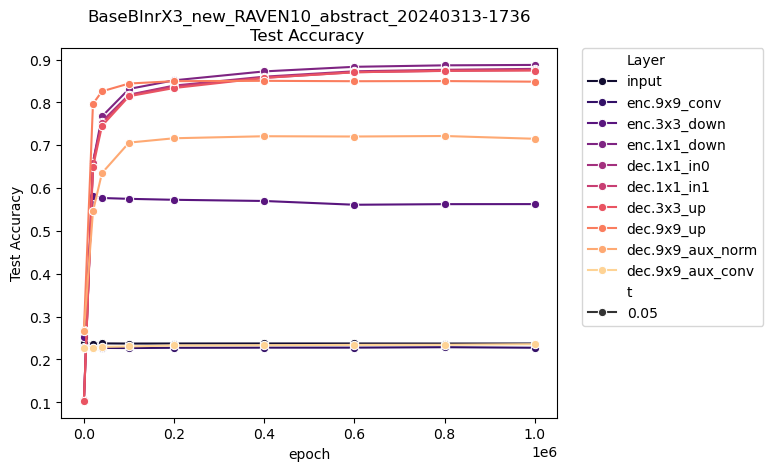

In [16]:
sns.lineplot(data=syn_df_all_base[syn_df_all_base["t"]==0.05], marker="o",
             x="epoch", y="Test Accuracy", hue="Layer", palette="magma", style="t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"{expname}\nTest Accuracy ")

### Wide model

In [17]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_wide = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

Text(0.5, 1.0, 'WideBlnrX3_new_RAVEN10_abstract_20240412-1347\nTest Accuracy')

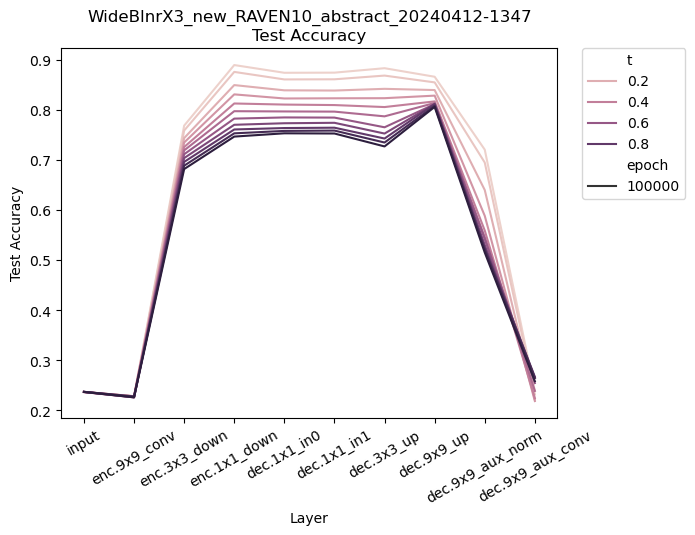

In [22]:
sns.lineplot(data=syn_df_all_wide[syn_df_all_wide["epoch"]==100000], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)
plt.title(f"{expname}\nTest Accuracy")

Text(0.5, 1.0, 'WideBlnrX3_new_RAVEN10_abstract_20240412-1347\nTest Accuracy')

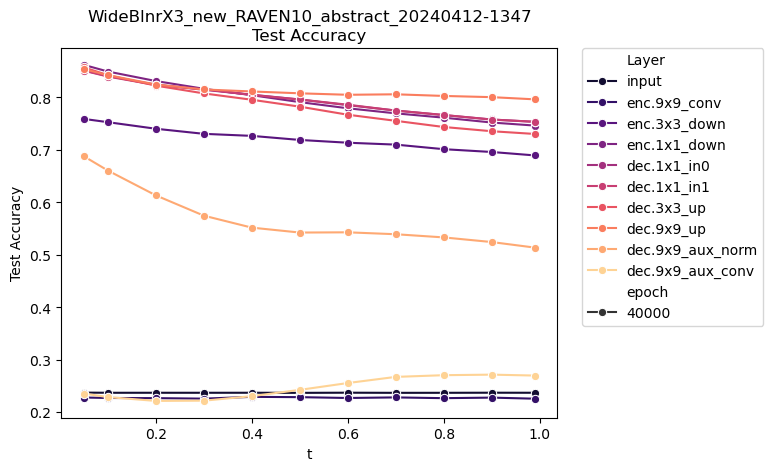

In [23]:
sns.lineplot(data=syn_df_all_wide[syn_df_all_wide["epoch"]==40000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"{expname}\nTest Accuracy")

Text(0.5, 1.0, 'WideBlnrX3_new_RAVEN10_abstract_20240412-1347\nTest Accuracy')

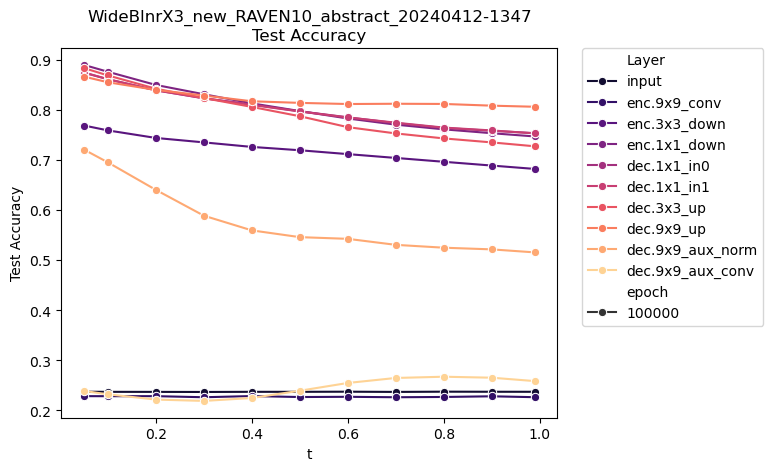

In [24]:
sns.lineplot(data=syn_df_all_wide[syn_df_all_wide["epoch"]==100000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"{expname}\nTest Accuracy")

Text(0.5, 1.0, 'WideBlnrX3_new_RAVEN10_abstract_20240412-1347\nTest Accuracy ')

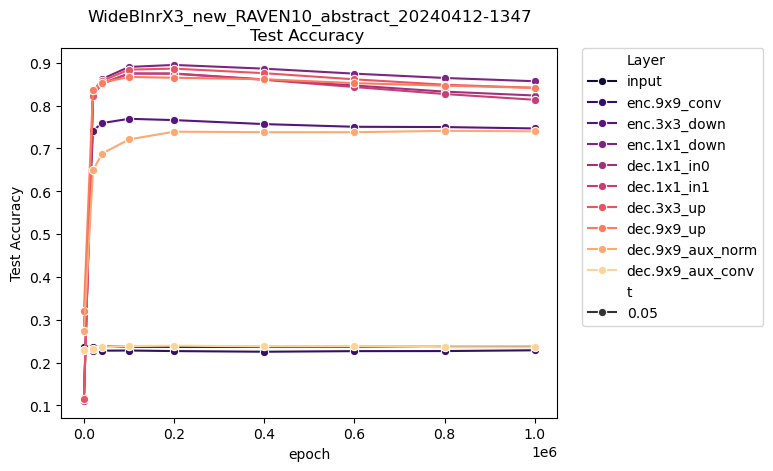

In [25]:
sns.lineplot(data=syn_df_all_wide[syn_df_all_wide["t"]==0.05], marker="o",
             x="epoch", y="Test Accuracy", hue="Layer", palette="magma", style="t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f"{expname}\nTest Accuracy ")

### No-attr wide model

In [11]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"WideBlnrX3_new_noattn_RAVEN10_abstract_20240412-1254"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_wide_noattr = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'input'),
  Text(1, 0, 'enc.9x9_conv'),
  Text(2, 0, 'enc.3x3_down'),
  Text(3, 0, 'enc.1x1_down'),
  Text(4, 0, 'dec.1x1_in0'),
  Text(5, 0, 'dec.1x1_in1'),
  Text(6, 0, 'dec.3x3_up'),
  Text(7, 0, 'dec.9x9_up'),
  Text(8, 0, 'dec.9x9_block2'),
  Text(9, 0, 'dec.9x9_aux_norm'),
  Text(10, 0, 'dec.9x9_aux_conv')])

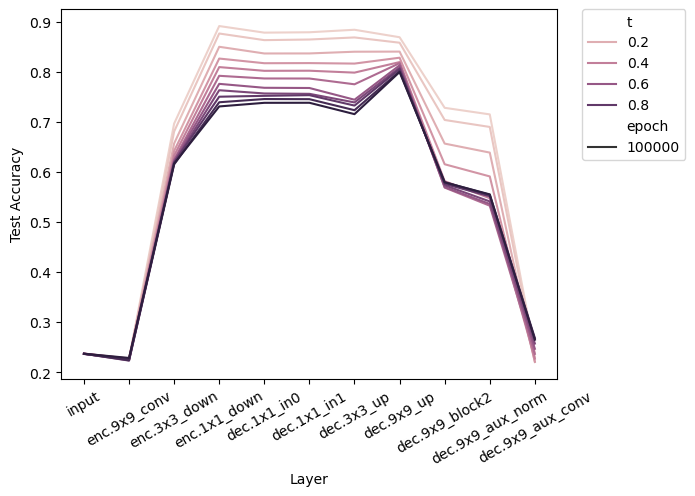

In [33]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==100000], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

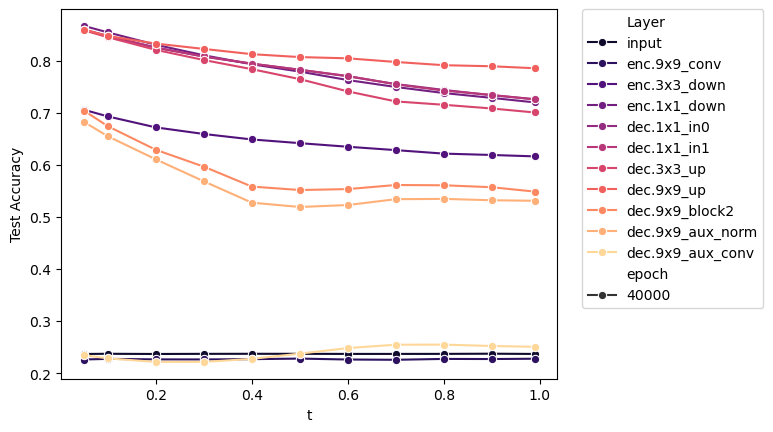

In [28]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==40000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

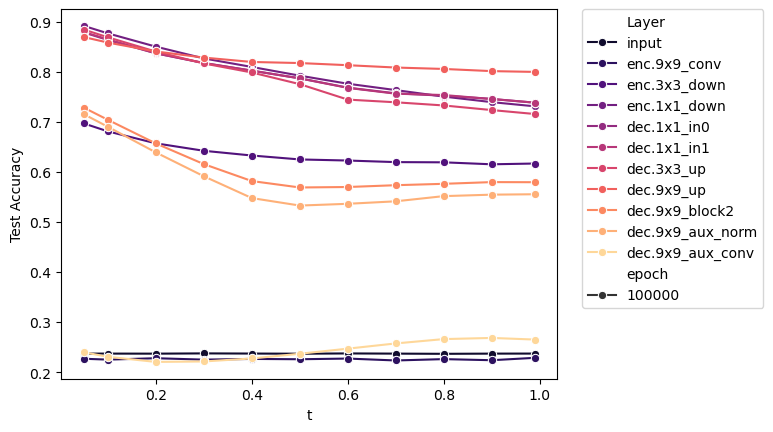

In [27]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==100000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

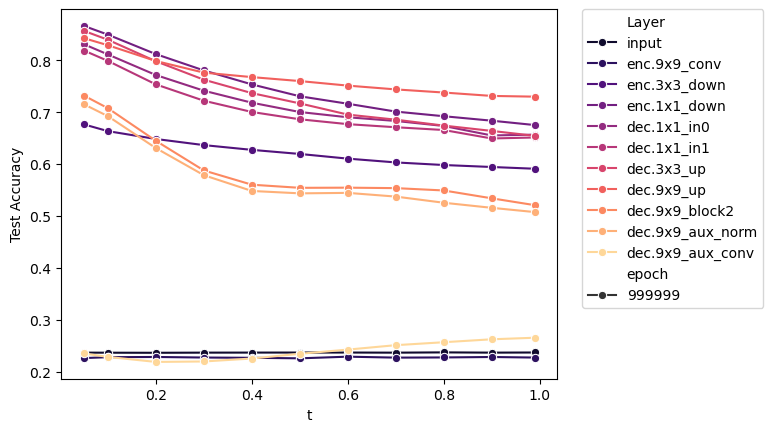

In [26]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==999999], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

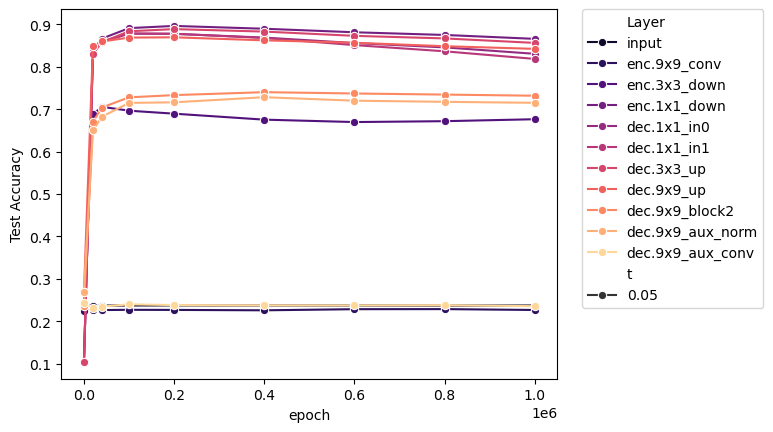

In [47]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["t"]==0.05], marker="o",
             x="epoch", y="Test Accuracy", hue="Layer", palette="magma", style="t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Big model

In [34]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"BigBlnrX3_new_RAVEN10_abstract_20240412-0143"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_big = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'input'),
  Text(1, 0, 'enc.9x9_conv'),
  Text(2, 0, 'enc.3x3_down'),
  Text(3, 0, 'enc.1x1_down'),
  Text(4, 0, 'dec.1x1_in0'),
  Text(5, 0, 'dec.1x1_in1'),
  Text(6, 0, 'dec.3x3_up'),
  Text(7, 0, 'dec.9x9_up'),
  Text(8, 0, 'dec.9x9_block2'),
  Text(9, 0, 'dec.9x9_aux_norm'),
  Text(10, 0, 'dec.9x9_aux_conv')])

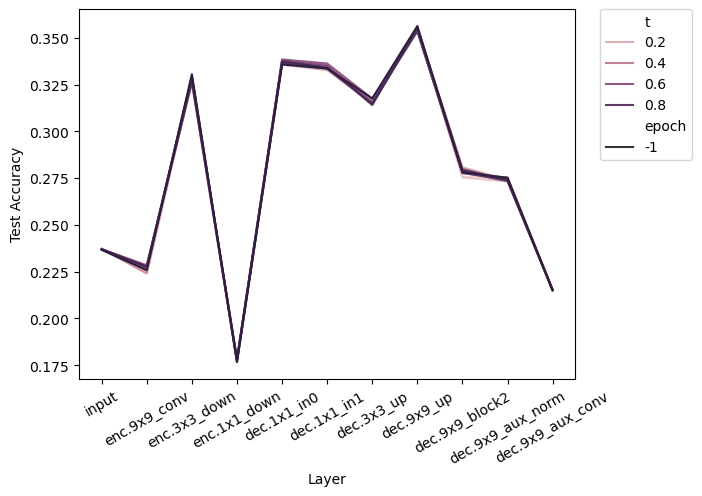

In [39]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==-1], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'input'),
  Text(1, 0, 'enc.9x9_conv'),
  Text(2, 0, 'enc.3x3_down'),
  Text(3, 0, 'enc.1x1_down'),
  Text(4, 0, 'dec.1x1_in0'),
  Text(5, 0, 'dec.1x1_in1'),
  Text(6, 0, 'dec.3x3_up'),
  Text(7, 0, 'dec.9x9_up'),
  Text(8, 0, 'dec.9x9_block2'),
  Text(9, 0, 'dec.9x9_aux_norm'),
  Text(10, 0, 'dec.9x9_aux_conv')])

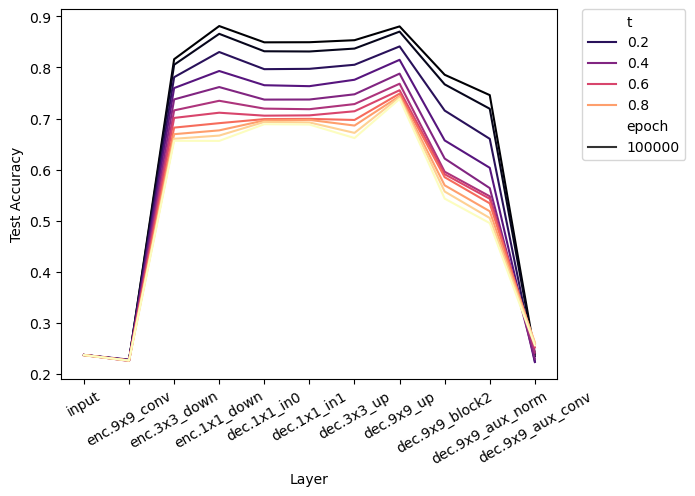

In [40]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==100000], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch",palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

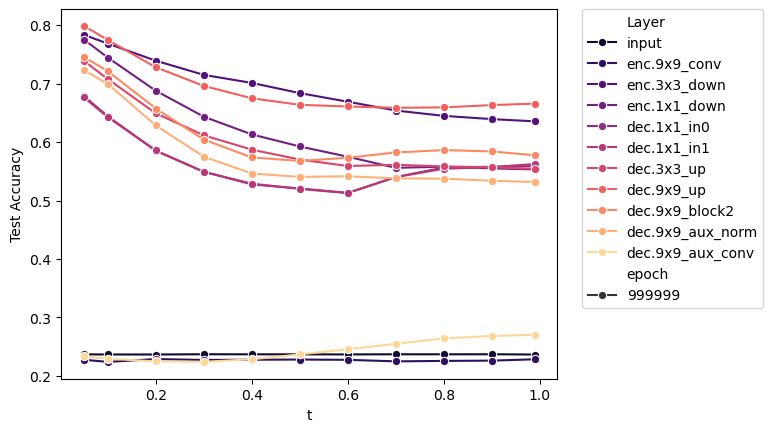

In [36]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==999999], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

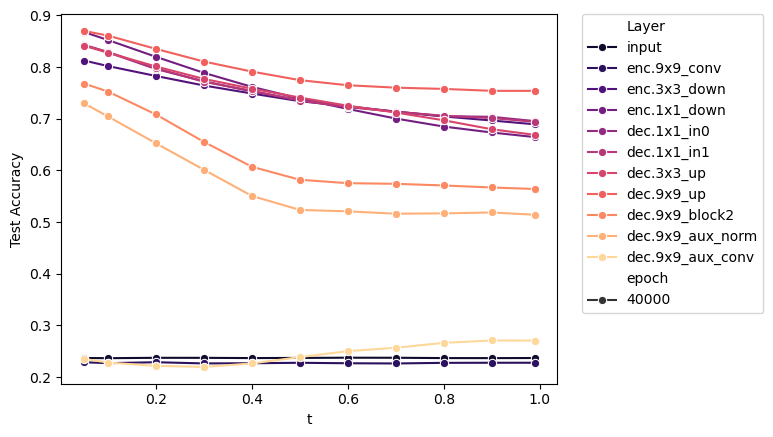

In [38]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==40000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Scratch zone

In [ ]:
list(results_col)

['input',
 'enc.9x9_conv',
 'enc.3x3_down',
 'enc.1x1_down',
 'dec.1x1_in0',
 'dec.1x1_in1',
 'dec.3x3_up',
 'dec.9x9_up',
 'dec.9x9_block2',
 'dec.9x9_aux_norm',
 'dec.9x9_aux_conv']

In [ ]:
(results_col['enc.1x1_down']['pred_cls'].cpu() == y_test).float().mean()

[1, 16, 20, 34, 37]

In [ ]:
mask_heldout = torch.isin(y_test, th.tensor(heldout_rules))
mask_in = ~mask_heldout
print(mask_heldout.sum(), mask_in.sum())

tensor(5000) tensor(35000)


In [ ]:
test_acc_synopsis_heldin = {}
test_acc_synopsis_heldout = {}
for key in results_col.keys():
    test_acc_synopsis_heldin[key] = (results_col[key]['pred_cls'].cpu()[mask_in] ==
                                     y_test[mask_in]).float().mean().item()
    test_acc_synopsis_heldout[key] = (results_col[key]['pred_cls'].cpu()[mask_heldout] ==
                                     y_test[mask_heldout]).float().mean().item()
    # print(key)
    # print((results_col[key]['pred_cls'].cpu()[mask_in] == y_test[mask_in]).float().mean())
    # print((results_col[key]['pred_cls'].cpu()[mask_heldout] == y_test[mask_heldout]).float().mean())

In [ ]:
for key in results_col.keys():
    print(key)
    print((results_col[key]['pred_cls'].cpu()[mask_in] == y_test[mask_in]).float().mean())
    print((results_col[key]['pred_cls'].cpu()[mask_heldout] == y_test[mask_heldout]).float().mean())

input
tensor(0.2124)
tensor(0.4072)
enc.9x9_conv
tensor(0.2056)
tensor(0.3854)
enc.3x3_down
tensor(0.7637)
tensor(0.8014)
enc.1x1_down
tensor(0.8627)
tensor(0.8760)
dec.1x1_in0
tensor(0.8530)
tensor(0.8652)
dec.1x1_in1
tensor(0.8528)
tensor(0.8650)
dec.3x3_up
tensor(0.8573)
tensor(0.8732)
dec.9x9_up
tensor(0.8502)
tensor(0.8632)
dec.9x9_block2
tensor(0.6949)
tensor(0.7332)
dec.9x9_aux_norm
tensor(0.6813)
tensor(0.7312)
dec.9x9_aux_conv
tensor(0.2139)
tensor(0.3724)
